# Import & show data

In [ ]:
!pip install bs4==0.0.1
!pip install gensim

You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


In [ ]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
import gensim
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
from gensim.models import FastText
from gensim.models import TfidfModel
from gensim.corpora import Dictionary
from sklearn.neighbors import NearestNeighbors

In [ ]:
df = pd.read_csv('../data/Questions.csv', encoding = "ISO-8859-1", nrows=30000, usecols=['Id', 'Title', 'Body'])
df.shape

(30000, 3)

In [ ]:
#Let's take a look at some of the questions
print('Question1: ', df.iloc[0, 2])
print('Question2: ', df.iloc[1, 2])
print('Question3: ', df.iloc[2, 2])

Question1:  <p>I am using the Photoshop's javascript API to find the fonts in a given PSD.</p>

<p>Given a font name returned by the API, I want to find the actual physical font file that that font name corresponds to on the disc.</p>

<p>This is all happening in a python program running on OSX so I guess I'm looking for one of:</p>

<ul>
<li>Some Photoshop javascript</li>
<li>A Python function</li>
<li>An OSX API that I can call from python</li>
</ul>

Question2:  <p>I have a cross-platform (Python) application which needs to generate a JPEG preview of the first page of a PDF.</p>

<p>On the Mac I am spawning <a href="http://developer.apple.com/documentation/Darwin/Reference/ManPages/man1/sips.1.html">sips</a>.  Is there something similarly simple I can do on Windows?</p>

Question3:  <p>I'm starting work on a hobby project with a python codebase and would like to set up some form of continuous integration (i.e. running a battery of test-cases each time a check-in is made and sending 

# Preprocessing

In [ ]:
#Using beautiful soup to grab text inside 'p' tags and concatenate it
def get_question(html_text):
  soup = BeautifulSoup(html_text, 'lxml')
  question = ' '.join([t.text for t in soup.find_all('p')]) #concatenating all p tags
  return question

#Transforming questions to list for ease of processing
question_list = df['Body'].apply(get_question).values.tolist()

In [ ]:
question_list[5]

"Django view points to a function, which can be a problem if you want to change only a bit of functionality. Yes, I could have million keyword arguments and even more if statements in the function, but I was thinking more of an object oriented approach. For example, I have a page that displays a user. This page is very similar to page that displays a group, but it's still not so similar to just use another data model. Group also has members etc... One way would be to point views to class methods and then extend that class. Has anyone tried this approach or has any other idea? "

In [ ]:
#Tokenizing with simple preprocess gensim's simple preprocess
def sent_to_words(sentences):
    for sentence in sentences:
        yield(simple_preprocess(str(sentence), deacc=True)) # returns lowercase tokens, ignoring tokens that are too short or too long

question_words = list(sent_to_words(question_list))

In [ ]:
question_words[0][0:10] #first 10 questions tokens

['am',
 'using',
 'the',
 'photoshop',
 'javascript',
 'api',
 'to',
 'find',
 'the',
 'fonts']

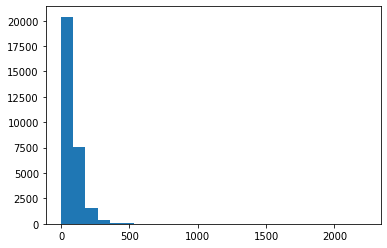

Mean word count of questions is 80.7959


In [ ]:
lengths = [len(question) for question in question_words]
plt.hist(lengths, bins = 25)
plt.show()

print('Mean word count of questions is %s' % np.mean(lengths))

In [ ]:
#Getting rid of stopwords
nltk.download('stopwords')
stop_words = stopwords.words('english')

def remove_stopwords(sentence):
  filtered_words = [word for word in sentence if word not in stop_words]
  return filtered_words

filtered_questions = [remove_stopwords(question) for question in question_words]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


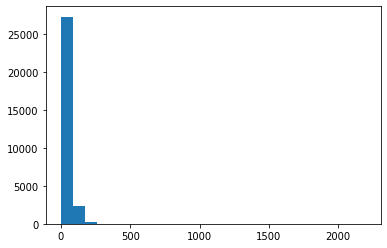

Mean word count of questions is 43.86006666666667


In [ ]:
#Examining word counts after removal of stop words

lengths = [len(question) for question in filtered_questions]
plt.hist(lengths, bins = 25)
plt.show()

print('Mean word count of questions is %s' % np.mean(lengths))

In [ ]:
len(filtered_questions)

30000

# Word2Vec

In [ ]:
#Instantiating the model
n = 50
model = Word2Vec(filtered_questions, size = n, window = 8)

#Training model using questions corpora
model.train(filtered_questions, total_examples=len(filtered_questions), epochs=10)

(11640221, 13158020)

In [ ]:
#Let's see how it worked
word_vectors = model.wv

print('Words similar to "array" are: ', word_vectors.most_similar(positive='array'))
print('Words similar to "database" are: ', word_vectors.most_similar(positive='database'))

Words similar to "array" are:  [('arrays', 0.8159111142158508), ('slice', 0.795966625213623), ('matrix', 0.7336535453796387), ('tuples', 0.7043884992599487), ('vector', 0.6829946041107178), ('numpy', 0.6820066571235657), ('transpose', 0.6765576601028442), ('dimensional', 0.6674408316612244), ('dimension', 0.6622238159179688), ('dtype', 0.640419602394104)]
Words similar to "database" are:  [('db', 0.8586743474006653), ('postgres', 0.7692910432815552), ('databases', 0.7286147475242615), ('postgresql', 0.7280545234680176), ('sqlite', 0.7145481109619141), ('mongodb', 0.6854144930839539), ('tables', 0.6848315596580505), ('mysql', 0.6807987689971924), ('jdbc', 0.680249810218811), ('table', 0.6682528257369995)]


# Fast Text

In [ ]:
ft_model = FastText(filtered_questions, size=n, window=8, min_count=5, workers=2,sg=1)

In [ ]:
print('Words similar to "array" are: ', ft_model.wv.most_similar('array'))
print('Words similar to "database" are: ', ft_model.wv.most_similar('database'))

Words similar to "array" are:  [('arrays', 0.9306490421295166), ('asarray', 0.9264801740646362), ('my_array', 0.9255294799804688), ('ndarray', 0.9097437262535095), ('recarray', 0.89760422706604), ('arraylist', 0.8941466212272644), ('bitarray', 0.8556662201881409), ('dimension', 0.8329317569732666), ('dimensional', 0.8138360977172852), ('bytearray', 0.8125293850898743)]
Words similar to "database" are:  [('databases', 0.9410210251808167), ('db', 0.882779598236084), ('postgres', 0.8594355583190918), ('database_engine', 0.8571964502334595), ('dbs', 0.848911702632904), ('psql', 0.8449884653091431), ('postgresql', 0.8340396285057068), ('zodb', 0.8258909583091736), ('sqlite', 0.8233659863471985), ('mssql', 0.8117862939834595)]


## Finding Similar Questions

In [ ]:
def get_n_most_similar(interest_index, embeddings, n):
    """
    Takes the embedding vector of interest, the list with all embeddings, and the number of similar questions to 
    retrieve.
    Outputs the disctionary IDs and distances
    """
    nbrs = NearestNeighbors(n_neighbors=n, metric='cosine').fit(embeddings)
    distances, indices = nbrs.kneighbors(embeddings)
    similar_indices = indices[interest_index][1:]
    similar_distances = distances[interest_index][1:]
    return similar_indices, similar_distances

def print_similar(interest_index, embeddings, n):
    """
    Convenience function for visual analysis
    """
    closest_ind, closest_dist = get_n_most_similar(interest_index, embeddings, n)
    print('Question %s \n \n is most similar to these %s questions: \n' % (question_list[interest_index], n))
    for question in closest_ind:
        print('ID ', question, ': ',question_list[question])

In [ ]:
print_similar(42, ft_sent, 5)

NameError: name 'ft_sent' is not defined

## Doc2Vec

In [ ]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(filtered_questions)]
model = Doc2Vec(documents, vector_size=n, window=8, min_count=5, workers=2, dm = 1, epochs=20)

In [ ]:
print(question_list[42], ' \nis similar to \n')
print([question_list[similar[0]] for similar in model.docvecs.most_similar(42)])

What's the best way to sanitise user input for a Python-based web application? Is there a single function to remove HTML characters and any other necessary characters combinations to prevent an XSS or SQL injection attack?  
is similar to 

['I C# we do it through reflection. In Javascript it is simple as: How to do it in Python?', "I have a website which fetches information from RSS feeds periodically (well, currently manually, and this is my problem).  This is currently implemented as a normal Django view, which isn't very nice in my opinion.  I'd like to have a Python program which is run using a cronjob instead of manually visiting the correct URL to update the information. What is the easiest way to make a Python program have access to my particular Django application and the Django ORM?", 'If I have the following code: I get the following error message: However, if I modify the code in the following way: everything is fine. Why? ', 'I would like to replace an object instance by a

In [ ]:
print_similar(90, ft_sent, 5)

NameError: name 'ft_sent' is not defined

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=3c29a683-71a2-405c-b0ad-9e789f7cae87' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>